In [1]:
cd /workspace/fast-influence-functions

/workspace/fast-influence-functions


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
import torch
import transformers
from tqdm import tqdm
from transformers import TrainingArguments
from transformers import default_data_collator
from transformers import AutoModelForSequenceClassification
from typing import Tuple, Dict, Any, Optional, List

from run_experiments import NUM_RETRAINING_EXPERIMENTS
from experiments import constants
from experiments import misc_utils
from experiments.data_utils import glue_output_modes
from experiments.mnli import (
    NUM_DATAPOINTS_TO_REMOVE_CHOICES,
    CORRECT_INDICES,
    INCORRECT_INDICES)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [4]:
tokenizer, _ = misc_utils.create_tokenizer_and_model(
    constants.MNLI_MODEL_PATH)

(_,
 mnli_eval_dataset) = misc_utils.create_datasets(
    task_name="mnli",
    tokenizer=tokenizer)

eval_instance_data_loader = misc_utils.get_dataloader(
    dataset=mnli_eval_dataset,
    batch_size=1,
    random=False)

Params Trainable: 14768643
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11.attention.self.key.weight
	bert.encoder.layer.11.attention.self.ke

In [5]:
def get_test_inputs_collections() -> List[int]:
    test_inputs_collections = {}
    for test_index, test_inputs in enumerate(eval_instance_data_loader):
        if test_index in (
                CORRECT_INDICES[:NUM_RETRAINING_EXPERIMENTS] +
                INCORRECT_INDICES[:NUM_RETRAINING_EXPERIMENTS]):

            test_inputs_collections[test_index] = test_inputs

    return test_inputs_collections

# Get the inputs collections
test_inputs_collections = get_test_inputs_collections()

In [7]:
display(NUM_DATAPOINTS_TO_REMOVE_CHOICES)
NUM_DATAPOINTS_TO_REMOVE_CHOICES = [5, 25]

[1, 5, 25]

In [8]:
# EXPERIMENTS_BASE_DIR = "/export/home/hguo/Experiments-backup/20201019"
EXPERIMENTS_BASE_DIR = "/export/home/hguo/Experiments/20201204"


def _load_model(
        mode: str,
        example_index: int,
        correct_mode: str,
        tag: str,
        num_data_points_to_remove: int
) -> Tuple[torch.nn.Module, transformers.Trainer]:
    if mode != "original":
        if mode in ["full"]:
            relative_dir = "full"
            # hostname = "g0306.ll.unc.edu"

        if mode in ["KNN-1000"]:
            relative_dir = "KNN-1000"
            # hostname = "g0303.ll.unc.edu"

        if mode in ["KNN-10000"]:
            relative_dir = "KNN-10000"
            # hostname = "g0303.ll.unc.edu"

        if mode in ["random"]:
            relative_dir = "random"
            # hostname = "g0310.ll.unc.edu"

        folder_name = (
            f"./retraining-remove-"
            f"{example_index}-"
            f"{correct_mode}-"
            f"{mode}-"
            f"{tag}-"
            f"{num_data_points_to_remove}"
            # f".{hostname}"
        )

        model_dir = os.path.join(
            EXPERIMENTS_BASE_DIR,
            relative_dir,
            folder_name,
            "output_dir")
    else:
        if not all([
                example_index is None,
                correct_mode is None,
                tag is None,
                num_data_points_to_remove is None
        ]):
            raise ValueError

        model_dir = constants.MNLI_MODEL_PATH

    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    model.eval()

    # Most of these arguments are placeholders
    # and are not really used at all, so ignore
    # the exact values of these.
    trainer = transformers.Trainer(
        model=model,
        args=TrainingArguments(
            output_dir="./tmp-output",
            per_device_train_batch_size=128,
            per_device_eval_batch_size=128,
            learning_rate=5e-5,
            logging_steps=100),
    )

    if model.training is True:
        raise ValueError
    
    print(f"Loading from {model_dir}")
    return model, trainer

def _compute_loss(
        trainer: transformers.Trainer,
        model: torch.nn.Module,
        inputs: Dict[str, Any],
) -> torch.Tensor:
    _, _, batch_mean_loss = misc_utils.predict(
        trainer=trainer,
        model=model,
        inputs=inputs)

    return batch_mean_loss


with tqdm(total=None) as pbar:
    loss_collections = []
    for mode in ["full", "KNN-1000", "KNN-10000", "random"]:
        for example_relative_index in range(NUM_RETRAINING_EXPERIMENTS):
            for correct_mode in ["correct", "incorrect"]:
                if correct_mode == "correct":
                    example_index = CORRECT_INDICES[example_relative_index]
                if correct_mode == "incorrect":
                    example_index = INCORRECT_INDICES[example_relative_index]

                if mode in ["full", "KNN-1000", "KNN-10000"]:
                    tags = ["helpful", "harmful"]

                elif mode in ["random"]:
                    tags = ["neutral", "entailment", "contradiction"]

                else:
                    raise ValueError

                for tag in tags:
                    for num_data_points_to_remove in NUM_DATAPOINTS_TO_REMOVE_CHOICES:
                        test_inputs = test_inputs_collections[example_index]

                        model, trainer = _load_model(
                            mode=mode,
                            example_index=example_index,
                            correct_mode=correct_mode,
                            tag=tag,
                            num_data_points_to_remove=num_data_points_to_remove)

                        loss = _compute_loss(
                            trainer=trainer,
                            model=model,
                            inputs=test_inputs)

                        loss_collections.append({
                            "mode": mode,
                            "correct_mode": correct_mode,
                            "example_index": example_index,
                            "tag": tag,
                            "num_data_points_to_remove": num_data_points_to_remove,
                            "loss": loss,
                        })

                        pbar.update(1)

0it [00:00, ?it/s]You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


Loading from /export/home/hguo/Experiments/20201204/full/./retraining-remove-0-correct-full-helpful-5/output_dir


1it [00:12, 12.88s/it]You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
2it [00:27, 13.28s/it]

Loading from /export/home/hguo/Experiments/20201204/full/./retraining-remove-0-correct-full-helpful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
3it [00:36, 12.08s/it]

Loading from /export/home/hguo/Experiments/20201204/full/./retraining-remove-0-correct-full-harmful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
4it [00:48, 12.19s/it]

Loading from /export/home/hguo/Experiments/20201204/full/./retraining-remove-0-correct-full-harmful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
5it [00:56, 10.73s/it]

Loading from /export/home/hguo/Experiments/20201204/full/./retraining-remove-3-incorrect-full-helpful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
6it [01:10, 11.88s/it]

Loading from /export/home/hguo/Experiments/20201204/full/./retraining-remove-3-incorrect-full-helpful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
7it [01:22, 11.71s/it]

Loading from /export/home/hguo/Experiments/20201204/full/./retraining-remove-3-incorrect-full-harmful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
8it [01:33, 11.56s/it]

Loading from /export/home/hguo/Experiments/20201204/full/./retraining-remove-3-incorrect-full-harmful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
9it [01:47, 12.51s/it]

Loading from /export/home/hguo/Experiments/20201204/full/./retraining-remove-1-correct-full-helpful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
10it [02:00, 12.61s/it]

Loading from /export/home/hguo/Experiments/20201204/full/./retraining-remove-1-correct-full-helpful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
11it [02:08, 11.02s/it]

Loading from /export/home/hguo/Experiments/20201204/full/./retraining-remove-1-correct-full-harmful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
12it [02:19, 11.12s/it]

Loading from /export/home/hguo/Experiments/20201204/full/./retraining-remove-1-correct-full-harmful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
13it [02:29, 10.84s/it]

Loading from /export/home/hguo/Experiments/20201204/full/./retraining-remove-14-incorrect-full-helpful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
14it [02:37,  9.85s/it]

Loading from /export/home/hguo/Experiments/20201204/full/./retraining-remove-14-incorrect-full-helpful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
15it [02:44,  9.11s/it]

Loading from /export/home/hguo/Experiments/20201204/full/./retraining-remove-14-incorrect-full-harmful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
16it [02:52,  8.63s/it]

Loading from /export/home/hguo/Experiments/20201204/full/./retraining-remove-14-incorrect-full-harmful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
17it [03:02,  9.26s/it]

Loading from /export/home/hguo/Experiments/20201204/full/./retraining-remove-2-correct-full-helpful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
18it [03:13,  9.81s/it]

Loading from /export/home/hguo/Experiments/20201204/full/./retraining-remove-2-correct-full-helpful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
19it [03:26, 10.60s/it]

Loading from /export/home/hguo/Experiments/20201204/full/./retraining-remove-2-correct-full-harmful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
20it [03:34,  9.74s/it]

Loading from /export/home/hguo/Experiments/20201204/full/./retraining-remove-2-correct-full-harmful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
21it [03:45, 10.18s/it]

Loading from /export/home/hguo/Experiments/20201204/full/./retraining-remove-15-incorrect-full-helpful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
22it [03:55, 10.32s/it]

Loading from /export/home/hguo/Experiments/20201204/full/./retraining-remove-15-incorrect-full-helpful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
23it [04:11, 11.82s/it]

Loading from /export/home/hguo/Experiments/20201204/full/./retraining-remove-15-incorrect-full-harmful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
24it [04:23, 11.87s/it]

Loading from /export/home/hguo/Experiments/20201204/full/./retraining-remove-15-incorrect-full-harmful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
25it [04:30, 10.56s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-1000/./retraining-remove-0-correct-KNN-1000-helpful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
26it [04:38,  9.65s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-1000/./retraining-remove-0-correct-KNN-1000-helpful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
27it [04:58, 12.95s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-1000/./retraining-remove-0-correct-KNN-1000-harmful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
28it [05:20, 15.67s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-1000/./retraining-remove-0-correct-KNN-1000-harmful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
29it [05:28, 13.30s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-1000/./retraining-remove-3-incorrect-KNN-1000-helpful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
30it [05:36, 11.65s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-1000/./retraining-remove-3-incorrect-KNN-1000-helpful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
31it [05:48, 11.75s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-1000/./retraining-remove-3-incorrect-KNN-1000-harmful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
32it [05:55, 10.37s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-1000/./retraining-remove-3-incorrect-KNN-1000-harmful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
33it [06:10, 11.75s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-1000/./retraining-remove-1-correct-KNN-1000-helpful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
34it [06:22, 11.74s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-1000/./retraining-remove-1-correct-KNN-1000-helpful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
35it [06:35, 12.14s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-1000/./retraining-remove-1-correct-KNN-1000-harmful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
36it [06:50, 12.99s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-1000/./retraining-remove-1-correct-KNN-1000-harmful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
37it [07:02, 12.58s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-1000/./retraining-remove-14-incorrect-KNN-1000-helpful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
38it [07:10, 11.28s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-1000/./retraining-remove-14-incorrect-KNN-1000-helpful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
39it [07:24, 12.31s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-1000/./retraining-remove-14-incorrect-KNN-1000-harmful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
40it [07:40, 13.30s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-1000/./retraining-remove-14-incorrect-KNN-1000-harmful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
41it [08:02, 15.86s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-1000/./retraining-remove-2-correct-KNN-1000-helpful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
42it [08:10, 13.52s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-1000/./retraining-remove-2-correct-KNN-1000-helpful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
43it [08:18, 11.78s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-1000/./retraining-remove-2-correct-KNN-1000-harmful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
44it [08:29, 11.54s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-1000/./retraining-remove-2-correct-KNN-1000-harmful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
45it [08:45, 13.05s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-1000/./retraining-remove-15-incorrect-KNN-1000-helpful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
46it [08:53, 11.38s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-1000/./retraining-remove-15-incorrect-KNN-1000-helpful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
47it [09:13, 14.00s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-1000/./retraining-remove-15-incorrect-KNN-1000-harmful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
48it [09:27, 13.99s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-1000/./retraining-remove-15-incorrect-KNN-1000-harmful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
49it [09:42, 14.31s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-10000/./retraining-remove-0-correct-KNN-10000-helpful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
50it [09:57, 14.66s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-10000/./retraining-remove-0-correct-KNN-10000-helpful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
51it [10:21, 17.45s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-10000/./retraining-remove-0-correct-KNN-10000-harmful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
52it [10:37, 16.86s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-10000/./retraining-remove-0-correct-KNN-10000-harmful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
53it [10:51, 16.13s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-10000/./retraining-remove-3-incorrect-KNN-10000-helpful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
54it [10:59, 13.50s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-10000/./retraining-remove-3-incorrect-KNN-10000-helpful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
55it [11:13, 13.65s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-10000/./retraining-remove-3-incorrect-KNN-10000-harmful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
56it [11:23, 12.70s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-10000/./retraining-remove-3-incorrect-KNN-10000-harmful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
57it [11:41, 14.15s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-10000/./retraining-remove-1-correct-KNN-10000-helpful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
58it [11:52, 13.31s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-10000/./retraining-remove-1-correct-KNN-10000-helpful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
59it [12:00, 11.63s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-10000/./retraining-remove-1-correct-KNN-10000-harmful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
60it [12:12, 11.92s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-10000/./retraining-remove-1-correct-KNN-10000-harmful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
61it [12:26, 12.49s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-10000/./retraining-remove-14-incorrect-KNN-10000-helpful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
62it [12:40, 13.06s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-10000/./retraining-remove-14-incorrect-KNN-10000-helpful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
63it [12:56, 13.84s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-10000/./retraining-remove-14-incorrect-KNN-10000-harmful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
64it [13:10, 13.87s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-10000/./retraining-remove-14-incorrect-KNN-10000-harmful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
65it [13:20, 12.75s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-10000/./retraining-remove-2-correct-KNN-10000-helpful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
66it [13:36, 13.53s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-10000/./retraining-remove-2-correct-KNN-10000-helpful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
67it [13:44, 11.87s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-10000/./retraining-remove-2-correct-KNN-10000-harmful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
68it [14:11, 16.49s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-10000/./retraining-remove-2-correct-KNN-10000-harmful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
69it [14:27, 16.48s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-10000/./retraining-remove-15-incorrect-KNN-10000-helpful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
70it [14:35, 13.74s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-10000/./retraining-remove-15-incorrect-KNN-10000-helpful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
71it [14:46, 13.06s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-10000/./retraining-remove-15-incorrect-KNN-10000-harmful-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
72it [15:04, 14.38s/it]

Loading from /export/home/hguo/Experiments/20201204/KNN-10000/./retraining-remove-15-incorrect-KNN-10000-harmful-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
73it [15:15, 13.36s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-0-correct-random-neutral-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
74it [15:22, 11.48s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-0-correct-random-neutral-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
75it [15:31, 10.89s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-0-correct-random-entailment-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
76it [15:38,  9.78s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-0-correct-random-entailment-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
77it [15:47,  9.31s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-0-correct-random-contradiction-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
78it [15:54,  8.65s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-0-correct-random-contradiction-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
79it [16:05,  9.40s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-3-incorrect-random-neutral-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
80it [16:20, 11.03s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-3-incorrect-random-neutral-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
81it [16:27,  9.83s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-3-incorrect-random-entailment-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
82it [16:36,  9.75s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-3-incorrect-random-entailment-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
83it [16:43,  8.93s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-3-incorrect-random-contradiction-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
84it [17:00, 11.27s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-3-incorrect-random-contradiction-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
85it [17:08, 10.17s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-1-correct-random-neutral-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
86it [17:22, 11.56s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-1-correct-random-neutral-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
87it [17:29, 10.21s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-1-correct-random-entailment-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
88it [17:44, 11.61s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-1-correct-random-entailment-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
89it [17:51, 10.28s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-1-correct-random-contradiction-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
90it [17:59,  9.34s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-1-correct-random-contradiction-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
91it [18:06,  8.70s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-14-incorrect-random-neutral-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
92it [18:18,  9.73s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-14-incorrect-random-neutral-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
93it [18:27,  9.57s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-14-incorrect-random-entailment-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
94it [18:37,  9.68s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-14-incorrect-random-entailment-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
95it [18:45,  9.03s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-14-incorrect-random-contradiction-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
96it [18:52,  8.46s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-14-incorrect-random-contradiction-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
97it [19:06, 10.12s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-2-correct-random-neutral-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
98it [19:13,  9.21s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-2-correct-random-neutral-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
99it [19:28, 10.94s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-2-correct-random-entailment-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
100it [19:40, 11.37s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-2-correct-random-entailment-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
101it [19:54, 12.16s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-2-correct-random-contradiction-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
102it [20:05, 11.86s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-2-correct-random-contradiction-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
103it [20:14, 10.80s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-15-incorrect-random-neutral-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
104it [20:21,  9.68s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-15-incorrect-random-neutral-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
105it [20:30,  9.60s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-15-incorrect-random-entailment-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
106it [20:44, 10.92s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-15-incorrect-random-entailment-25/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
107it [20:52,  9.86s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-15-incorrect-random-contradiction-5/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
108it [21:03, 11.70s/it]

Loading from /export/home/hguo/Experiments/20201204/random/./retraining-remove-15-incorrect-random-contradiction-25/output_dir


In [16]:
# example_index = 2
# correct_mode = "correct"
# mode = "KNN-10000"
# tag = "helpful"
# num_data_points_to_remove = 100

# model = _load_model(
#     example_index=example_index,
#     correct_mode=correct_mode,
#     mode=mode, tag=tag,
#     num_data_points_to_remove=num_data_points_to_remove)
# inputs = test_inputs_collections[0]

In [17]:
for example_relative_index in range(NUM_RETRAINING_EXPERIMENTS):
    for correct_mode in ["correct", "incorrect"]:
        if correct_mode == "correct":
            example_index = CORRECT_INDICES[example_relative_index]
        if correct_mode == "incorrect":
            example_index = INCORRECT_INDICES[example_relative_index]

        test_inputs = test_inputs_collections[example_index]

        model, trainer = _load_model(
            mode="original",
            example_index=None,
            correct_mode=None,
            tag=None,
            num_data_points_to_remove=None)

        loss = _compute_loss(
            trainer=trainer,
            model=model,
            inputs=test_inputs)

        loss_collections.append({
            "mode": "original",
            "correct_mode": correct_mode,
            "example_index": example_index,
            "tag": None,
            "num_data_points_to_remove": None,
            "loss": loss,
        })

        pbar.update(1)

You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


Loading from /export/home/hguo/Experiments/20200706/


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


Loading from /export/home/hguo/Experiments/20200706/


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


Loading from /export/home/hguo/Experiments/20200706/


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


Loading from /export/home/hguo/Experiments/20200706/


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


Loading from /export/home/hguo/Experiments/20200706/


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


Loading from /export/home/hguo/Experiments/20200706/


In [4]:
import torch

# Old version, which used [1, 100, 10000]
# torch.save(loss_collections, "/export/home/hguo/Experiments/20201102/loss_collections.20201102.pt")
# loss_collections_old = torch.load("/export/home/hguo/Experiments/20201102/loss_collections.20201102.pt")

loss_collections = []
# New version, which used [1]
# torch.save(loss_collections, "/export/home/hguo/Experiments/20201205/loss_collections.202012005.1.pt")
loss_collections += torch.load("/export/home/hguo/Experiments/20201205/loss_collections.202012005.1.pt")
# New version, which used [5, 25]
# torch.save(loss_collections, "/export/home/hguo/Experiments/20201205/loss_collections.202012005.5-25.pt")
loss_collections += torch.load("/export/home/hguo/Experiments/20201205/loss_collections.202012005.5-25.pt")

In [5]:
import pandas as pd
loss_df = pd.DataFrame(loss_collections)

def _get_loss_diff(row):
    loss_diff = loss_df[
        (loss_df["mode"] == "original") &
        (loss_df["correct_mode"] == row["correct_mode"]) &
        (loss_df["example_index"] == row["example_index"])
    ]["loss"].values

    if loss_diff.shape != (1, ):
        raise ValueError

    return loss_diff[0]


loss_df["loss_diff"] = loss_df.apply(lambda row: row["loss"] - _get_loss_diff(row), axis=1)

if not (loss_df[loss_df["mode"] == "original"].loss_diff.values == 0.0).all():
    raise ValueError

# loss_df = loss_df[loss_df.example_index.isin([0, 15, 14])]

In [6]:
new_losses_mean = pd.DataFrame(
    loss_df[loss_df["mode"] != "original"]
    .groupby(["mode", "correct_mode", "tag", "num_data_points_to_remove"])
    ["loss_diff"].mean()
).to_dict()["loss_diff"]

new_losses_std = pd.DataFrame(
    loss_df[loss_df["mode"] != "original"]
    .groupby(["mode", "correct_mode", "tag", "num_data_points_to_remove"])
    ["loss_diff"].std()
).to_dict()["loss_diff"]

original_losses_mean = pd.DataFrame(
    loss_df[loss_df["mode"] == "original"]
    .groupby(["mode", "correct_mode"])
    ["loss_diff"].mean()
).to_dict()["loss_diff"]

original_losses_std = pd.DataFrame(
    loss_df[loss_df["mode"] == "original"]
    .groupby(["mode", "correct_mode"])
    ["loss_diff"].std()
).to_dict()["loss_diff"]

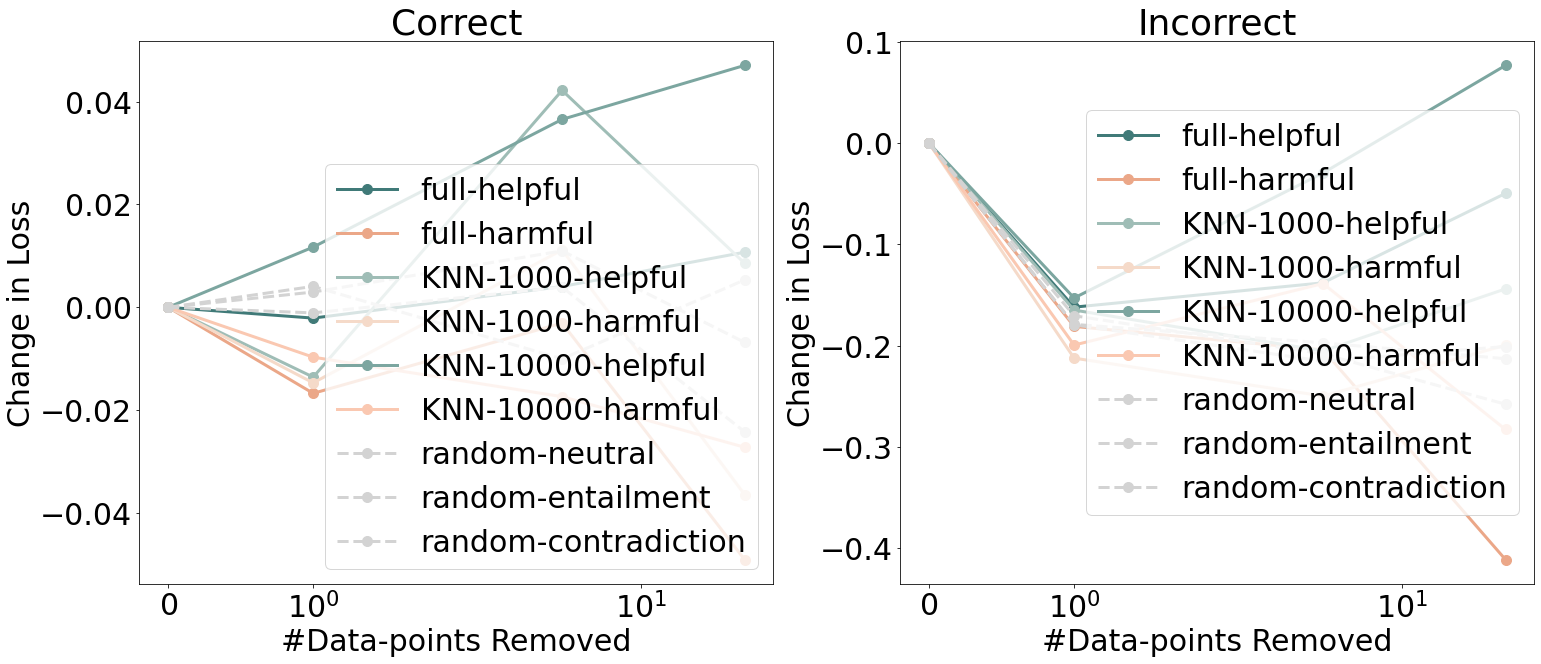

In [8]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25, 10)
plt.rcParams.update({"font.size": 30})
figure, axes = plt.subplots(1, 2, sharex=True)


for mode in ["full", "KNN-1000", "KNN-10000", "random"]:
    for axis_index, correct_mode in enumerate(["correct", "incorrect"]):

        if mode in ["full", "KNN-1000", "KNN-10000"]:
            tags = ["helpful", "harmful"]

        elif mode in ["random"]:
            tags = ["neutral", "entailment", "contradiction"]

        else:
            raise ValueError

        for tag in tags:
            Xs = [0]# [0, 1, 100, 10000]
            Ys_mean = [original_losses_mean[("original", correct_mode)]]
            Ys_std_min = [
                original_losses_mean[("original", correct_mode)] -
                original_losses_std[("original", correct_mode)]
            ]
            Ys_std_max = [
                original_losses_mean[("original", correct_mode)] +
                original_losses_std[("original", correct_mode)]
            ]
            for num_data_points_to_remove in NUM_DATAPOINTS_TO_REMOVE_CHOICES:
                Xs.append(num_data_points_to_remove)
                Ys_mean.append(
                    new_losses_mean[(mode, correct_mode, tag, num_data_points_to_remove)]
                )

                Ys_std_min.append(
                    new_losses_mean[(mode, correct_mode, tag, num_data_points_to_remove)] -
                    new_losses_std[(mode, correct_mode, tag, num_data_points_to_remove)]
                )
                Ys_std_max.append(
                    new_losses_mean[(mode, correct_mode, tag, num_data_points_to_remove)] +
                    new_losses_std[(mode, correct_mode, tag, num_data_points_to_remove)]
                )

            axes[axis_index].plot(
                Xs, Ys_mean,
                linestyle=("-" if mode != "random" else "--"),
                marker="o",
                label=f"{mode}-{tag}",
                linewidth=3,
                markersize=10,
                color={
                    ("full", "helpful"): "#407A78",
                    ("KNN-10000", "helpful"): "#7CA6A0",
                    ("KNN-1000", "helpful"): "#9FBDB6",
                    ("full", "harmful"): "#EBA788",
                    ("KNN-10000", "harmful"): "#FAC8B1",
                    ("KNN-1000", "harmful"): "#F5DAC9",
                    ("random", "neutral"): "lightgrey",
                    ("random", "entailment"): "lightgrey",
                    ("random", "contradiction"): "lightgrey",
                }[(mode, tag)])
            axes[axis_index].legend()
            axes[axis_index].set_xscale("symlog")
            # axes[axis_index].set_yscale("symlog")
            axes[axis_index].set_xlabel("#Data-points Removed")
            axes[axis_index].set_ylabel("Change in Loss")
            axes[axis_index].set_title(f"{correct_mode.capitalize()}")
#             if correct_mode == "correct":
#                 axes[axis_index].set_ylim(top=0.25, bottom=-0.25)
#             else:
#                 axes[axis_index].set_ylim(top=0.75, bottom=-0.75)

figure.savefig("./20201205-retraining-with-legend.pdf")

In [8]:
# for column, correct_mode in enumerate(["correct", "incorrect"]):
#     for mode in ["full", "KNN-1000", "KNN-10000"]:
#         for row, tag in enumerate(["helpful", "harmful"]):

#     for random_label in ["neutral", "entailment", "contradiction"]:
#         Xs = [0, 1, 2, 3]# [0, 1, 100, 10000]
#         Ys_mean = [
#             original_losses_mean[("original", correct_mode)]
#         ] + [
#             losses_mean[("random", correct_mode, random_label, n)] for n in [1, 100, 10000]
#         ]

#         Ys_std_min = [
#             original_losses_mean[("original", correct_mode)] -
#             original_losses_std[("original", correct_mode)]
#         ] + [
#             losses_mean[("random", correct_mode, random_label, n)] -
#             losses_std[("random", correct_mode, random_label, n)]
#             for n in [1, 100, 10000]
#         ]

#         Ys_std_max = [
#             original_losses_mean[("original", correct_mode)] +
#             original_losses_std[("original", correct_mode)]
#         ] + [
#             losses_mean[("random", correct_mode, random_label, n)] +
#             losses_std[("random", correct_mode, random_label, n)]
#             for n in [1, 100, 10000]
#         ]
#         axes[column].plot(Xs, Ys_mean, label=f"{random_label}", linestyle="--")
#         axes[column].legend()
#         if correct_mode == "correct":
#             axes[column].set_ylim(top=0.2, bottom=-0.25)
#         else:
#             axes[column].set_ylim(top=0.25, bottom=-0.5)
#         axes[column].set_title(f"{correct_mode}")

In [145]:
# for mode in ["full", "KNN-1000", "KNN-10000"]:
#     Xs = [0, 1, 100, 10000]
#     Ys = [
#         original_losses_mean[("original", "correct")]
#     ] + [
#         losses_mean[(mode, "incorrect", "harmful", n)] for n in [1, 100, 10000]
#     ]
#     plt.plot(Xs, Ys, label=mode)

# plt.legend()
# plt.xscale("log")